
# üéØ Objetivo: Detectar toxicidad con datos aumentados

## üìã Estrategia:
### - Eliminar columnas desbalanceadas
### - Aplicar Data Augmentation con traducci√≥n
### - Preprocesar texto eficientemente
### - Entrenar XGboost

In [2]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de texto
import re
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
import xgboost as xgb

# Para augmentaci√≥n simple
import random
from textblob import TextBlob

# Persistencia
import pickle
from datetime import datetime

# Configuraci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar datos y an√°lisis inicial

In [3]:

df = pd.read_csv('../data/youtoxic_english_1000.csv')
print(f"‚úÖ Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# Columnas de toxicidad
columnas_toxicidad = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                      'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
                      'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']



‚úÖ Dataset original: 1000 filas, 15 columnas


# 2. Identificar y eliminar columnas desbalanceadas

In [4]:
print("\nüîç Analizando balance de columnas...")

# Calcular balance
balance = {}
UMBRAL = 5.0  # 5% m√≠nimo

for col in columnas_toxicidad:
    porcentaje = (df[col].sum() / len(df)) * 100
    balance[col] = porcentaje
    estado = "‚úÖ Mantener" if porcentaje >= UMBRAL else "‚ùå Eliminar"
    print(f"{col:20} -> {porcentaje:5.1f}% {estado}")

# Seleccionar solo columnas balanceadas
columnas_mantener = [col for col in columnas_toxicidad if balance[col] >= UMBRAL]
columnas_eliminar = [col for col in columnas_toxicidad if balance[col] < UMBRAL]

print(f"\nüìä Resumen:")
print(f"   - Columnas a mantener: {len(columnas_mantener)}")
print(f"   - Columnas a eliminar: {len(columnas_eliminar)}")

# Crear etiqueta binaria solo con columnas balanceadas
df['toxic_binary'] = (df[columnas_mantener].sum(axis=1) > 0).astype(int)

# Eliminar columnas desbalanceadas del dataset
df = df.drop(columns=columnas_eliminar)

print(f"\n‚úÖ Nueva distribuci√≥n de toxicidad:")
print(df['toxic_binary'].value_counts())
print(f"Porcentaje t√≥xico: {df['toxic_binary'].mean()*100:.1f}%")


üîç Analizando balance de columnas...
IsAbusive            ->  35.3% ‚úÖ Mantener
IsThreat             ->   2.1% ‚ùå Eliminar
IsProvocative        ->  16.1% ‚úÖ Mantener
IsObscene            ->  10.0% ‚úÖ Mantener
IsHatespeech         ->  13.8% ‚úÖ Mantener
IsRacist             ->  12.5% ‚úÖ Mantener
IsNationalist        ->   0.8% ‚ùå Eliminar
IsSexist             ->   0.1% ‚ùå Eliminar
IsHomophobic         ->   0.0% ‚ùå Eliminar
IsReligiousHate      ->   1.2% ‚ùå Eliminar
IsRadicalism         ->   0.0% ‚ùå Eliminar

üìä Resumen:
   - Columnas a mantener: 5
   - Columnas a eliminar: 6

‚úÖ Nueva distribuci√≥n de toxicidad:
toxic_binary
0    538
1    462
Name: count, dtype: int64
Porcentaje t√≥xico: 46.2%


# 3. Preprocesamiento de texto

In [5]:
print("\nüßπ Preparando funciones de preprocesamiento...")

# Inicializar herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    """Limpieza r√°pida y eficiente del texto"""
    if pd.isna(texto):
        return ""
    
    texto = str(texto).lower()
    texto = re.sub(r'@\w+|http\S+|www\S+', '', texto)  # URLs y menciones
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Solo letras
    texto = ' '.join(texto.split())  # Espacios extras
    
    return texto

def procesar_texto(texto):
    """Procesamiento completo con lemmatizaci√≥n"""
    # Tokenizar
    palabras = word_tokenize(texto)
    
    # Filtrar stopwords y palabras cortas
    palabras = [lemmatizer.lemmatize(p) for p in palabras 
                if p not in stop_words and len(p) > 2]
    
    return ' '.join(palabras)


üßπ Preparando funciones de preprocesamiento...


# 4. Data augmentation

In [6]:
print("\nüåê Configurando Data Augmentation...")

def augmentar_texto_avanzado(texto):
    """
    Aumenta datos usando t√©cnicas que no requieren APIs externas.
    Genera m√∫ltiples variaciones del texto original.
    """
    variaciones = []
    
    # 1. Reemplazo de sin√≥nimos comunes
    sinonimos = {
        'hate': ['despise', 'loathe', 'detest'],
        'stupid': ['dumb', 'idiotic', 'foolish', 'moronic'],
        'bad': ['terrible', 'awful', 'horrible'],
        'good': ['great', 'excellent', 'wonderful'],
        'idiot': ['fool', 'moron', 'imbecile'],
        'ugly': ['hideous', 'repulsive', 'disgusting'],
        'fat': ['obese', 'overweight', 'heavy'],
        'kill': ['murder', 'destroy', 'eliminate'],
        'die': ['perish', 'expire', 'pass away'],
        'trash': ['garbage', 'rubbish', 'waste'],
        'suck': ['terrible', 'awful', 'horrible'],
        'dumb': ['stupid', 'idiotic', 'brainless']
    }
    
    # Variaci√≥n 1: Reemplazar sin√≥nimos
    texto_sinonimos = texto.lower()
    for palabra, alternativas in sinonimos.items():
        if palabra in texto_sinonimos:
            for alternativa in alternativas[:2]:  # Usar m√°ximo 2 sin√≥nimos
                nuevo_texto = texto_sinonimos.replace(palabra, alternativa)
                if nuevo_texto != texto_sinonimos:
                    variaciones.append(nuevo_texto)
    
    # 2. Inserci√≥n de ruido controlado
    palabras = texto.split()
    if len(palabras) > 5:
        # Variaci√≥n 2: Eliminar palabras no esenciales
        palabras_importantes = [p for p in palabras if len(p) > 3]
        if len(palabras_importantes) > 3:
            variaciones.append(' '.join(palabras_importantes))
        
        # Variaci√≥n 3: Cambiar orden de frases
        if '.' in texto or '!' in texto or '?' in texto:
            import re
            frases = re.split(r'[.!?]+', texto)
            frases = [f.strip() for f in frases if f.strip()]
            if len(frases) > 1:
                random.shuffle(frases)
                variaciones.append('. '.join(frases) + '.')
    
    # 3. Par√°frasis simple usando TextBlob (sin traducci√≥n)
    try:
        blob = TextBlob(texto)
        # Cambiar tiempos verbales si es posible
        if blob.tags:
            texto_modificado = str(blob)
            # Intercambiar algunas palabras comunes
            intercambios = [
                ('you are', "you're"), ("you're", 'you are'),
                ('i am', "i'm"), ("i'm", 'i am'),
                ('do not', "don't"), ("don't", 'do not'),
                ('will not', "won't"), ("won't", 'will not')
            ]
            for original, reemplazo in intercambios:
                if original in texto_modificado.lower():
                    texto_modificado = texto_modificado.lower().replace(original, reemplazo)
                    if texto_modificado != texto.lower():
                        variaciones.append(texto_modificado)
                        break
    except:
        pass
    
    # 4. Agregar/quitar puntuaci√≥n excesiva (com√∫n en comentarios t√≥xicos)
    if any(c in texto for c in ['!', '?', '...']):
        # Reducir puntuaci√≥n
        texto_reducido = re.sub(r'[!]+', '!', texto)
        texto_reducido = re.sub(r'[?]+', '?', texto_reducido)
        texto_reducido = re.sub(r'\.{3,}', '...', texto_reducido)
        if texto_reducido != texto:
            variaciones.append(texto_reducido)
        
        # Aumentar puntuaci√≥n (para comentarios t√≥xicos)
        texto_aumentado = texto.replace('!', '!!!')
        texto_aumentado = texto_aumentado.replace('?', '???')
        if texto_aumentado != texto:
            variaciones.append(texto_aumentado)
    
    # Eliminar duplicados y retornar
    return list(set(variaciones))[:3]  # M√°ximo 3 variaciones por texto


üåê Configurando Data Augmentation...


# 5. Aplicar augmentation a comentarios t√≥xicos 

In [7]:
print("\nüîÑ Aplicando Data Augmentation a comentarios t√≥xicos...")

# Separar comentarios t√≥xicos para aumentar
df_toxicos = df[df['toxic_binary'] == 1].copy()
df_no_toxicos = df[df['toxic_binary'] == 0].copy()

print(f"Comentarios t√≥xicos originales: {len(df_toxicos)}")
print(f"Comentarios no t√≥xicos: {len(df_no_toxicos)}")

# Aplicar augmentation
comentarios_aumentados = []
etiquetas_aumentadas = []
contador = 0

for idx, row in df_toxicos.iterrows():
    texto_limpio = limpiar_texto(row['Text'])
    
    # Generar variaciones
    variaciones = augmentar_texto_avanzado(texto_limpio)
    
    for variacion in variaciones:
        if variacion and len(variacion) > 10:  # Solo agregar si tiene contenido
            comentarios_aumentados.append(variacion)
            etiquetas_aumentadas.append(1)
            contador += 1
    
    # Mostrar progreso
    if idx % 50 == 0:
        print(f"   Procesados: {idx}/{len(df_toxicos)} - Generados: {contador} nuevos")

# Crear DataFrame con datos aumentados
df_aumentados = pd.DataFrame({
    'Text': comentarios_aumentados,
    'toxic_binary': etiquetas_aumentadas
})

print(f"\n‚úÖ Comentarios t√≥xicos generados: {len(df_aumentados)}")

# Combinar datasets
df_final = pd.concat([
    df[['Text', 'toxic_binary']],
    df_aumentados
], ignore_index=True)

# Mezclar aleatoriamente
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nüìä Dataset final:")
print(f"   - Total comentarios: {len(df_final)}")
print(f"   - T√≥xicos: {df_final['toxic_binary'].sum()}")
print(f"   - No t√≥xicos: {len(df_final) - df_final['toxic_binary'].sum()}")
print(f"   - Balance: {df_final['toxic_binary'].mean()*100:.1f}% t√≥xicos")


üîÑ Aplicando Data Augmentation a comentarios t√≥xicos...
Comentarios t√≥xicos originales: 462
Comentarios no t√≥xicos: 538


   Procesados: 50/462 - Generados: 55 nuevos
   Procesados: 100/462 - Generados: 104 nuevos
   Procesados: 150/462 - Generados: 155 nuevos
   Procesados: 250/462 - Generados: 232 nuevos
   Procesados: 350/462 - Generados: 295 nuevos
   Procesados: 600/462 - Generados: 434 nuevos
   Procesados: 750/462 - Generados: 545 nuevos
   Procesados: 900/462 - Generados: 617 nuevos

‚úÖ Comentarios t√≥xicos generados: 688

üìä Dataset final:
   - Total comentarios: 1688
   - T√≥xicos: 1150
   - No t√≥xicos: 538
   - Balance: 68.1% t√≥xicos


# 6. Preprocesar el dataset

In [8]:
print("\n‚è≥ Preprocesando todos los textos...")

# Aplicar limpieza y procesamiento
df_final['texto_limpio'] = df_final['Text'].apply(limpiar_texto)
df_final['texto_procesado'] = df_final['texto_limpio'].apply(procesar_texto)

# Eliminar filas vac√≠as
df_final = df_final[df_final['texto_procesado'].str.len() > 0]

print(f"‚úÖ Textos procesados: {len(df_final)}")

# Guardar dataset procesado
df_final.to_csv('../data/dataset_toxicidad_aumentado.csv', index=False)
print("üíæ Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv")




‚è≥ Preprocesando todos los textos...
‚úÖ Textos procesados: 1688
üíæ Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv


# 7. Visualizaci√≥n de datos

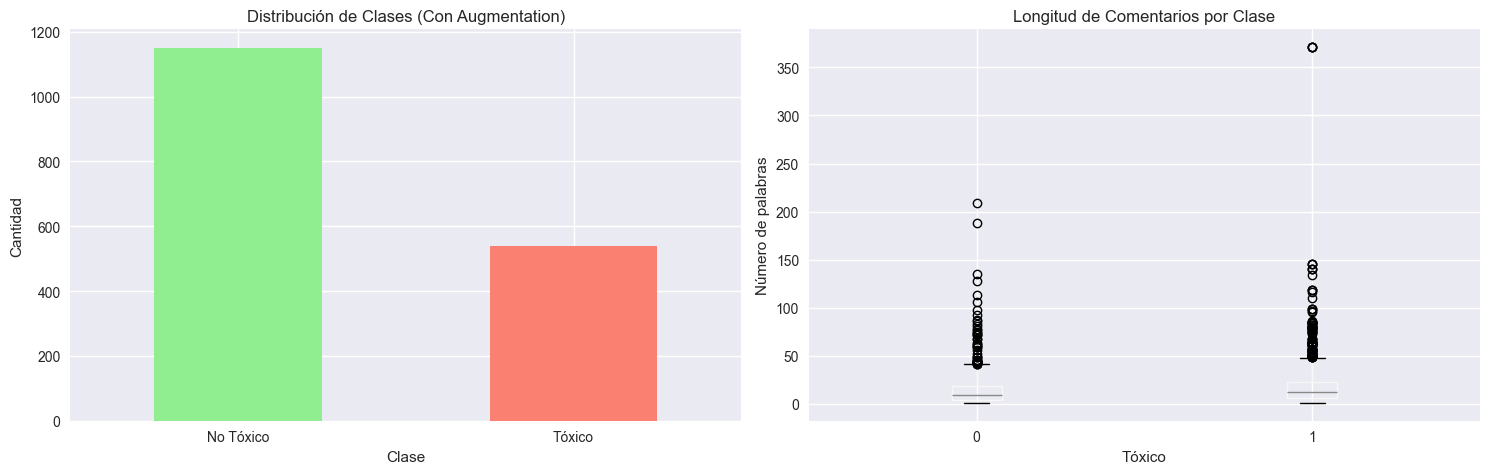

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Balance de clases
df_final['toxic_binary'].value_counts().plot(kind='bar', ax=axes[0], 
                                            color=['lightgreen', 'salmon'])
axes[0].set_title('Distribuci√≥n de Clases (Con Augmentation)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No T√≥xico', 'T√≥xico'], rotation=0)

# Longitud de comentarios
df_final['longitud'] = df_final['texto_procesado'].str.split().str.len()
df_final.boxplot(column='longitud', by='toxic_binary', ax=axes[1])
axes[1].set_title('Longitud de Comentarios por Clase')
axes[1].set_xlabel('T√≥xico')
axes[1].set_ylabel('N√∫mero de palabras')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Wordclouds comparativos


üìä WORDCLOUDS COMPARATIVOS
   ‚Ä¢ Comentarios t√≥xicos para WordCloud: 1150
   ‚Ä¢ Comentarios no t√≥xicos para WordCloud: 538
   ‚Ä¢ Palabras en corpus t√≥xico: 23197
   ‚Ä¢ Palabras en corpus no t√≥xico: 8785


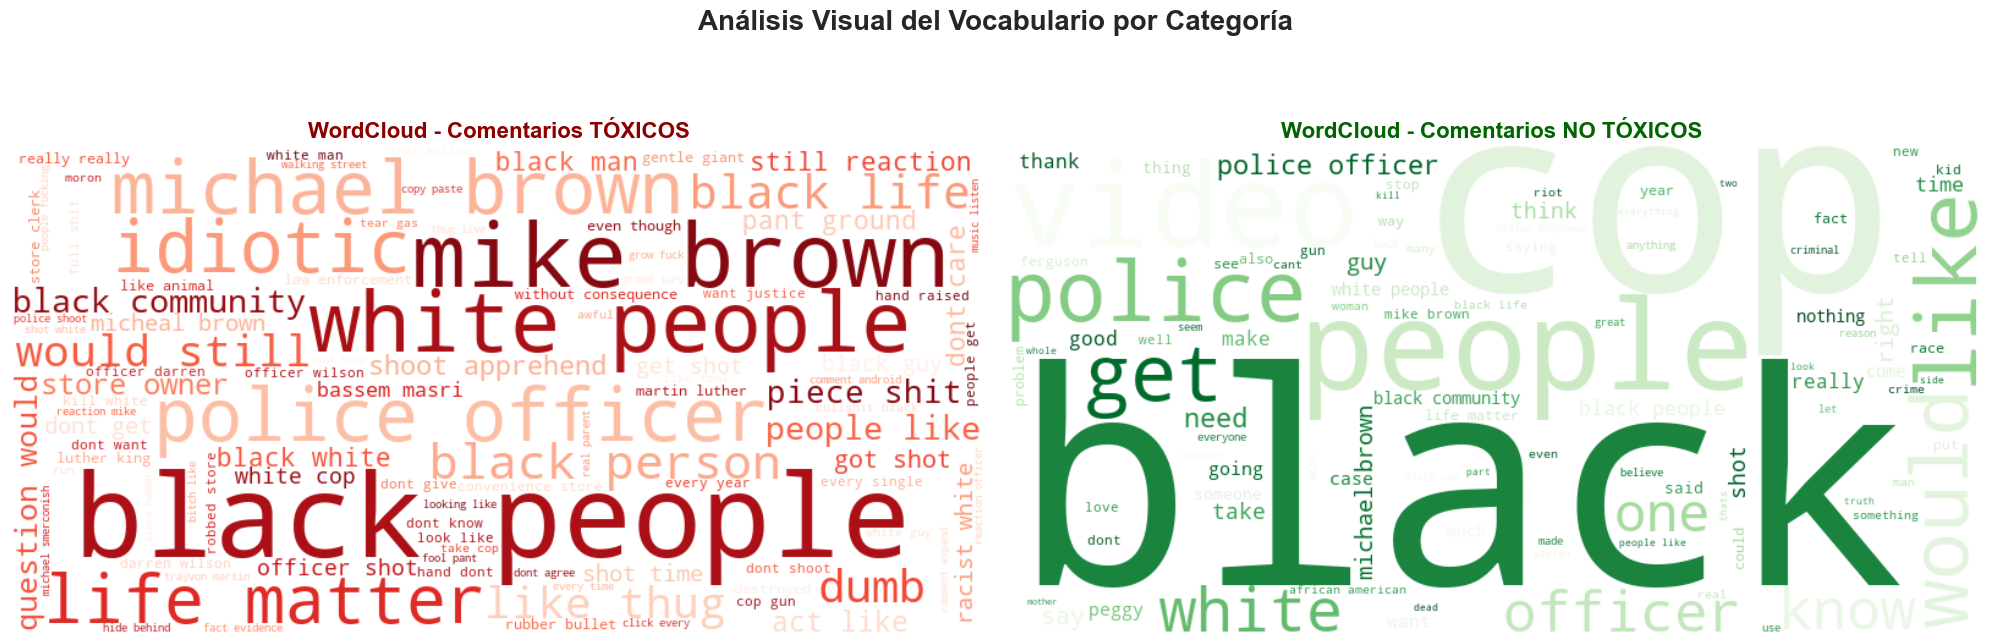

In [10]:
print("\nüìä WORDCLOUDS COMPARATIVOS")

# Separar textos por categor√≠a usando los datos procesados
textos_toxicos = df_final[df_final['toxic_binary'] == 1]['texto_procesado']
textos_no_toxicos = df_final[df_final['toxic_binary'] == 0]['texto_procesado']

print(f"   ‚Ä¢ Comentarios t√≥xicos para WordCloud: {len(textos_toxicos)}")
print(f"   ‚Ä¢ Comentarios no t√≥xicos para WordCloud: {len(textos_no_toxicos)}")

# Combinar textos por categor√≠a
texto_toxico_combinado = ' '.join(textos_toxicos.dropna())
texto_no_toxico_combinado = ' '.join(textos_no_toxicos.dropna())

print(f"   ‚Ä¢ Palabras en corpus t√≥xico: {len(texto_toxico_combinado.split())}")
print(f"   ‚Ä¢ Palabras en corpus no t√≥xico: {len(texto_no_toxico_combinado.split())}")

# Verificar que tenemos suficiente texto
if len(texto_toxico_combinado.split()) < 10:
    print("‚ö†Ô∏è Advertencia: Poco texto t√≥xico disponible para WordCloud")
if len(texto_no_toxico_combinado.split()) < 10:
    print("‚ö†Ô∏è Advertencia: Poco texto no t√≥xico disponible para WordCloud")

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Configuraci√≥n com√∫n para ambos WordClouds
wordcloud_config = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 100,
    'relative_scaling': 0.5,
    'stopwords': stop_words,  # Usar las mismas stopwords del preprocesamiento
    'collocation_threshold': 10
}

# WordCloud para comentarios t√≥xicos
if len(texto_toxico_combinado.strip()) > 0:
    wordcloud_toxico = WordCloud(
        **wordcloud_config,
        colormap='Reds'
    ).generate(texto_toxico_combinado)
    
    axes[0].imshow(wordcloud_toxico, interpolation='bilinear')
    axes[0].set_title('WordCloud - Comentarios T√ìXICOS', fontweight='bold', fontsize=16, color='darkred')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No hay suficiente\ntexto t√≥xico', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=16)
    axes[0].set_title('WordCloud - Comentarios T√ìXICOS', fontweight='bold', fontsize=16, color='darkred')

# WordCloud para comentarios no t√≥xicos
if len(texto_no_toxico_combinado.strip()) > 0:
    wordcloud_no_toxico = WordCloud(
        **wordcloud_config,
        colormap='Greens'
    ).generate(texto_no_toxico_combinado)
    
    axes[1].imshow(wordcloud_no_toxico, interpolation='bilinear')
    axes[1].set_title('WordCloud - Comentarios NO T√ìXICOS', fontweight='bold', fontsize=16, color='darkgreen')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No hay suficiente\ntexto no t√≥xico', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('WordCloud - Comentarios NO T√ìXICOS', fontweight='bold', fontsize=16, color='darkgreen')

plt.suptitle('An√°lisis Visual del Vocabulario por Categor√≠a', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 8. Preparaci√≥n para machine learning

In [11]:
print("\nüéØ Preparando datos para entrenamiento...")

# Features y target
X = df_final['texto_procesado']
y = df_final['toxic_binary']

# Divisi√≥n estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"üìä Divisi√≥n de datos:")
print(f"   - Entrenamiento: {len(X_train)} ({y_train.mean()*100:.1f}% t√≥xicos)")
print(f"   - Prueba: {len(X_test)} ({y_test.mean()*100:.1f}% t√≥xicos)")


üéØ Preparando datos para entrenamiento...
üìä Divisi√≥n de datos:
   - Entrenamiento: 1350 (68.1% t√≥xicos)
   - Prueba: 338 (68.0% t√≥xicos)


# 9. Vectorizaci√≥n optimizada

In [12]:
print("\nüî¢ Vectorizando con TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=2000,      # M√°s features por m√°s datos
    ngram_range=(1, 3),     # Incluir trigramas
    min_df=2,               # M√≠nima frecuencia
    max_df=0.95,            # M√°xima frecuencia
    sublinear_tf=True,      # Escalado logar√≠tmico
    use_idf=True,           # IDF para ponderar importancia
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"‚úÖ Forma de datos vectorizados: {X_train_vec.shape}")


üî¢ Vectorizando con TF-IDF...
‚úÖ Forma de datos vectorizados: (1350, 2000)


# 10. Entrenamiento de XGBoost

In [13]:
print("\nüöÄ Entrenando XGBoost optimizado...")

# Calcular peso de clases para balanceo
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Modelo XGBoost con hiperpar√°metros optimizados
modelo = xgb.XGBClassifier(
    # Par√°metros b√°sicos
    n_estimators=300,           # N√∫mero de √°rboles
    max_depth=6,                # Profundidad m√°xima
    learning_rate=0.1,          # Tasa de aprendizaje
    
    # Control de overfitting
    subsample=0.8,              # Submuestreo de filas
    colsample_bytree=0.8,       # Submuestreo de columnas
    reg_alpha=0.1,              # Regularizaci√≥n L1
    reg_lambda=1.0,             # Regularizaci√≥n L2
    
    # Balanceo de clases
    scale_pos_weight=scale_pos_weight,
    
    # Otros par√°metros
    objective='binary:logistic',
    eval_metric=['error', 'logloss'],  # M√©tricas de evaluaci√≥n
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    early_stopping_rounds=20    # Early stopping
)

# Entrenar con conjunto de validaci√≥n
eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)]
modelo.fit(
    X_train_vec, y_train,
    eval_set=eval_set,
    verbose=False
)

# Obtener informaci√≥n del entrenamiento
resultado_entrenamiento = modelo.evals_result()
if resultado_entrenamiento:
    # Obtener el mejor score de la validaci√≥n
    val_scores = resultado_entrenamiento['validation_1']['logloss']
    mejor_iteracion = np.argmin(val_scores)
    mejor_score = val_scores[mejor_iteracion]
    print(f"‚úÖ Mejor iteraci√≥n: {mejor_iteracion + 1}")
    print(f"‚úÖ Mejor score (logloss): {mejor_score:.4f}")

# Validaci√≥n cruzada con modelo sin early stopping
print("\nüìà Realizando validaci√≥n cruzada...")
modelo_cv = xgb.XGBClassifier(
    n_estimators=100,  # Menos √°rboles para CV r√°pida
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

scores_cv = cross_val_score(modelo_cv, X_train_vec, y_train, cv=5, scoring='f1')
print(f"   - F1-Scores: {[f'{s:.3f}' for s in scores_cv]}")
print(f"   - Media: {scores_cv.mean():.3f} (+/- {scores_cv.std() * 2:.3f})")


üöÄ Entrenando XGBoost optimizado...
‚úÖ Mejor iteraci√≥n: 256
‚úÖ Mejor score (logloss): 0.4043

üìà Realizando validaci√≥n cruzada...
   - F1-Scores: ['0.796', '0.820', '0.756', '0.780', '0.788']
   - Media: 0.788 (+/- 0.042)


# 11. Evaluaci√≥n detallada


üìä EVALUACI√ìN EN CONJUNTO DE PRUEBA:

üéØ M√©tricas principales:
   - Accuracy: 0.834
   - F1-Score: 0.875

üìã Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

   No T√≥xico      0.717     0.796     0.754       108
      T√≥xico      0.899     0.852     0.875       230

    accuracy                          0.834       338
   macro avg      0.808     0.824     0.815       338
weighted avg      0.841     0.834     0.836       338



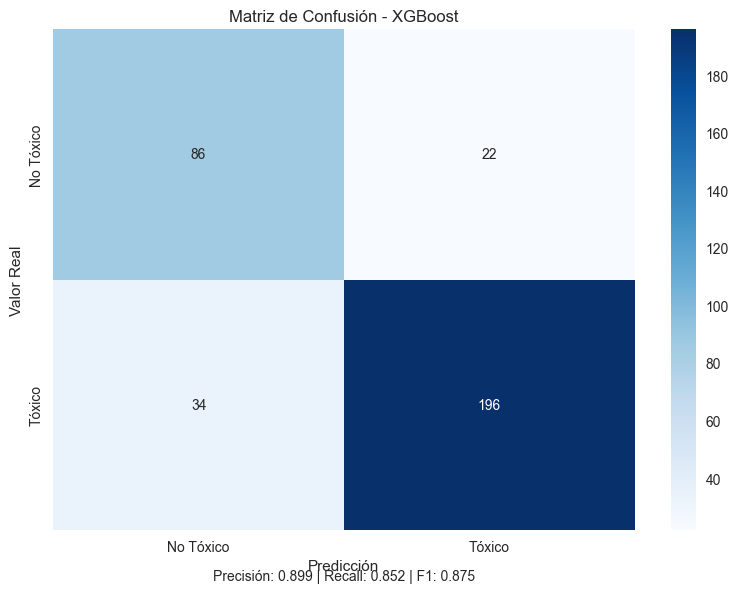

In [14]:
print("\nüìä EVALUACI√ìN EN CONJUNTO DE PRUEBA:")

# Predicciones
y_pred = modelo.predict(X_test_vec)
y_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]

# M√©tricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nüéØ M√©tricas principales:")
print(f"   - Accuracy: {accuracy:.3f}")
print(f"   - F1-Score: {f1:.3f}")

# Reporte completo
print("\nüìã Reporte de clasificaci√≥n:")
print(classification_report(y_test, y_pred, 
                          target_names=['No T√≥xico', 'T√≥xico'],
                          digits=3))

# Matriz de confusi√≥n
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No T√≥xico', 'T√≥xico'],
            yticklabels=['No T√≥xico', 'T√≥xico'])
plt.title('Matriz de Confusi√≥n - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Predicci√≥n')

# Agregar m√©tricas en el t√≠tulo
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.1, f'Precisi√≥n: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
         ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 12. An√°lisis de importancia de features


üî§ AN√ÅLISIS DE IMPORTANCIA DE FEATURES:

üèÜ Top 20 features m√°s importantes:
   'fuck': 0.0225
   'shit': 0.0142
   'black life matter': 0.0126
   'thug': 0.0119
   'dumb': 0.0118
   'video': 0.0113
   'fucking': 0.0113
   'away': 0.0104
   'idiot': 0.0097
   'moron': 0.0096
   'peggy': 0.0096
   'something': 0.0094
   'idiotic': 0.0094
   'shoot': 0.0093
   'arrest': 0.0089
   'stupid': 0.0087
   'black': 0.0087
   'truth': 0.0086
   'woman': 0.0084
   'bitch': 0.0083


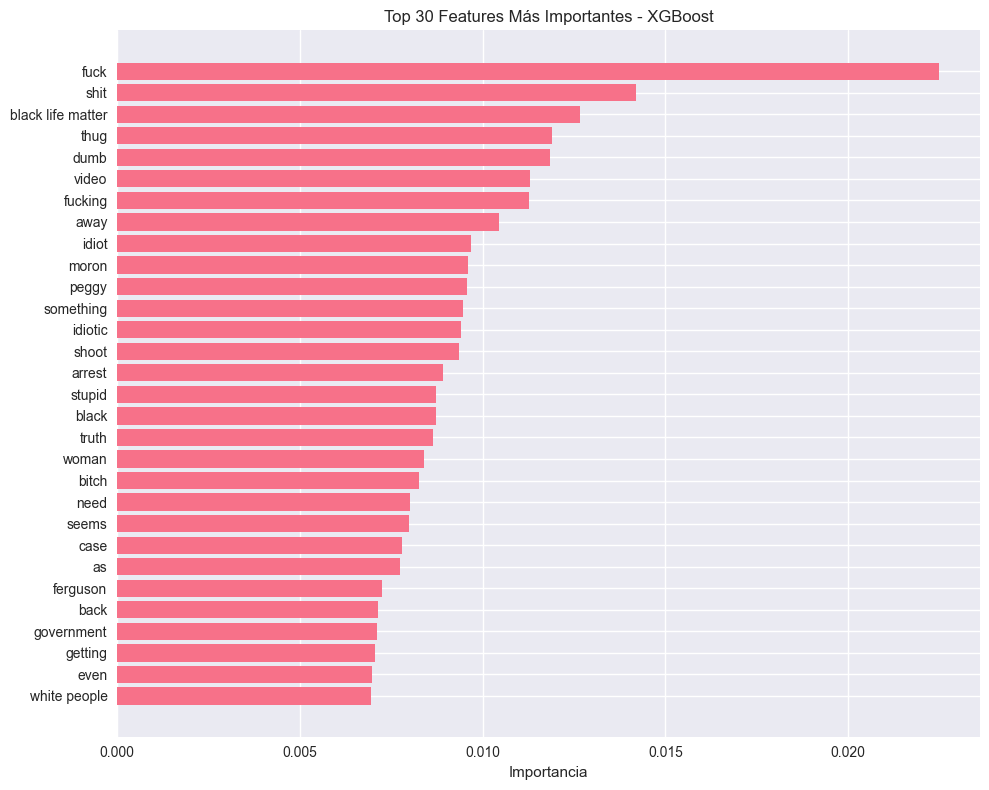


üìä An√°lisis detallado de importancia:

WEIGHT:
   'people': 79.0000
   'black': 60.0000
   'cop': 53.0000
   'shot': 46.0000
   'police': 43.0000
   'would': 41.0000
   'brown': 37.0000
   'fuck': 33.0000
   'like': 30.0000
   'one': 29.0000

GAIN:
   'fuck': 7.3495
   'shit': 4.6381
   'black life matter': 4.1351
   'thug': 3.8846
   'dumb': 3.8668
   'video': 3.6936
   'fucking': 3.6791
   'away': 3.4106
   'idiot': 3.1602
   'moron': 3.1337

COVER:
   'arrest': 139.5535
   'fuck': 134.4340
   'idiotic': 127.6287
   'dumb': 127.5237
   'cunt': 127.0026
   'fucking': 126.8976
   'moron': 126.5008
   'shit': 125.9425
   'thug': 125.1730
   'whole': 124.8064


In [15]:
print("\nüî§ AN√ÅLISIS DE IMPORTANCIA DE FEATURES:")

# Obtener importancia de features de XGBoost
feature_names = vectorizer.get_feature_names_out()
importancias = modelo.feature_importances_

# Crear DataFrame de importancias
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

# Top 20 features m√°s importantes
print("\nüèÜ Top 20 features m√°s importantes:")
for idx, row in df_importancia.head(20).iterrows():
    print(f"   '{row['feature']}': {row['importance']:.4f}")

# Visualizar importancia de features
plt.figure(figsize=(10, 8))
top_features = df_importancia.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Features M√°s Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# An√°lisis adicional: Gain vs Cover
if hasattr(modelo, 'get_booster'):
    print("\nüìä An√°lisis detallado de importancia:")
    importance_types = ['weight', 'gain', 'cover']
    
    for imp_type in importance_types:
        importances_dict = modelo.get_booster().get_score(importance_type=imp_type)
        if importances_dict:
            print(f"\n{imp_type.upper()}:")
            sorted_imp = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
            for feat, score in sorted_imp:
                if feat.startswith('f'):
                    feat_idx = int(feat[1:])
                    feat_name = feature_names[feat_idx]
                    print(f"   '{feat_name}': {score:.4f}")

# 13. Funci√≥n de predicci√≥n

In [16]:
def predecir_toxicidad(texto, modelo=modelo, vectorizer=vectorizer):
    """
    Predice si un comentario es t√≥xico.
    
    Retorna:
    - etiqueta: 'T√ìXICO' o 'NO T√ìXICO'
    - confianza: probabilidad de la predicci√≥n
    """
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    texto_procesado = procesar_texto(texto_limpio)
    
    # Vectorizar
    texto_vec = vectorizer.transform([texto_procesado])
    
    # Predecir
    prediccion = modelo.predict(texto_vec)[0]
    probabilidad = modelo.predict_proba(texto_vec)[0, 1]
    
    etiqueta = "T√ìXICO ‚ö†Ô∏è" if prediccion == 1 else "NO T√ìXICO ‚úÖ"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    return etiqueta, confianza

# Probar con ejemplos
print("\nüß™ PRUEBAS CON COMENTARIOS NUEVOS:")

ejemplos = [
    "Great video, thanks for sharing!",
    "You're so stupid and ignorant",
    "I disagree with your opinion",
    "This is garbage content, delete it",
    "Interesting perspective, never thought about it that way"
]

for comentario in ejemplos:
    etiqueta, confianza = predecir_toxicidad(comentario)
    print(f"\nüìù '{comentario}'")
    print(f"   ‚Üí {etiqueta} (Confianza: {confianza:.1%})")


üß™ PRUEBAS CON COMENTARIOS NUEVOS:

üìù 'Great video, thanks for sharing!'
   ‚Üí NO T√ìXICO ‚úÖ (Confianza: 89.2%)

üìù 'You're so stupid and ignorant'
   ‚Üí T√ìXICO ‚ö†Ô∏è (Confianza: 76.6%)

üìù 'I disagree with your opinion'
   ‚Üí NO T√ìXICO ‚úÖ (Confianza: 60.9%)

üìù 'This is garbage content, delete it'
   ‚Üí NO T√ìXICO ‚úÖ (Confianza: 60.9%)

üìù 'Interesting perspective, never thought about it that way'
   ‚Üí NO T√ìXICO ‚úÖ (Confianza: 85.7%)


# 14. An√°lisis de overfitting


üîç AN√ÅLISIS DE OVERFITTING

üìä COMPARACI√ìN DE M√âTRICAS POR CONJUNTO:
----------------------------------------

Entrenamiento:
  ACCURACY: 0.9178
  PRECISION: 0.9915
  RECALL: 0.8870
  F1: 0.9363
  AUC: 0.9867

Prueba:
  ACCURACY: 0.8343
  PRECISION: 0.8991
  RECALL: 0.8522
  F1: 0.8750
  AUC: 0.8833

üö® DETECCI√ìN DE OVERFITTING:
------------------------------
üìà F1 Train vs Test: 0.0613
‚ö†Ô∏è  OVERFITTING MODERADO detectado (Train >> Test)

üìä GENERANDO VISUALIZACIONES...
üìà Calculando curvas de aprendizaje...


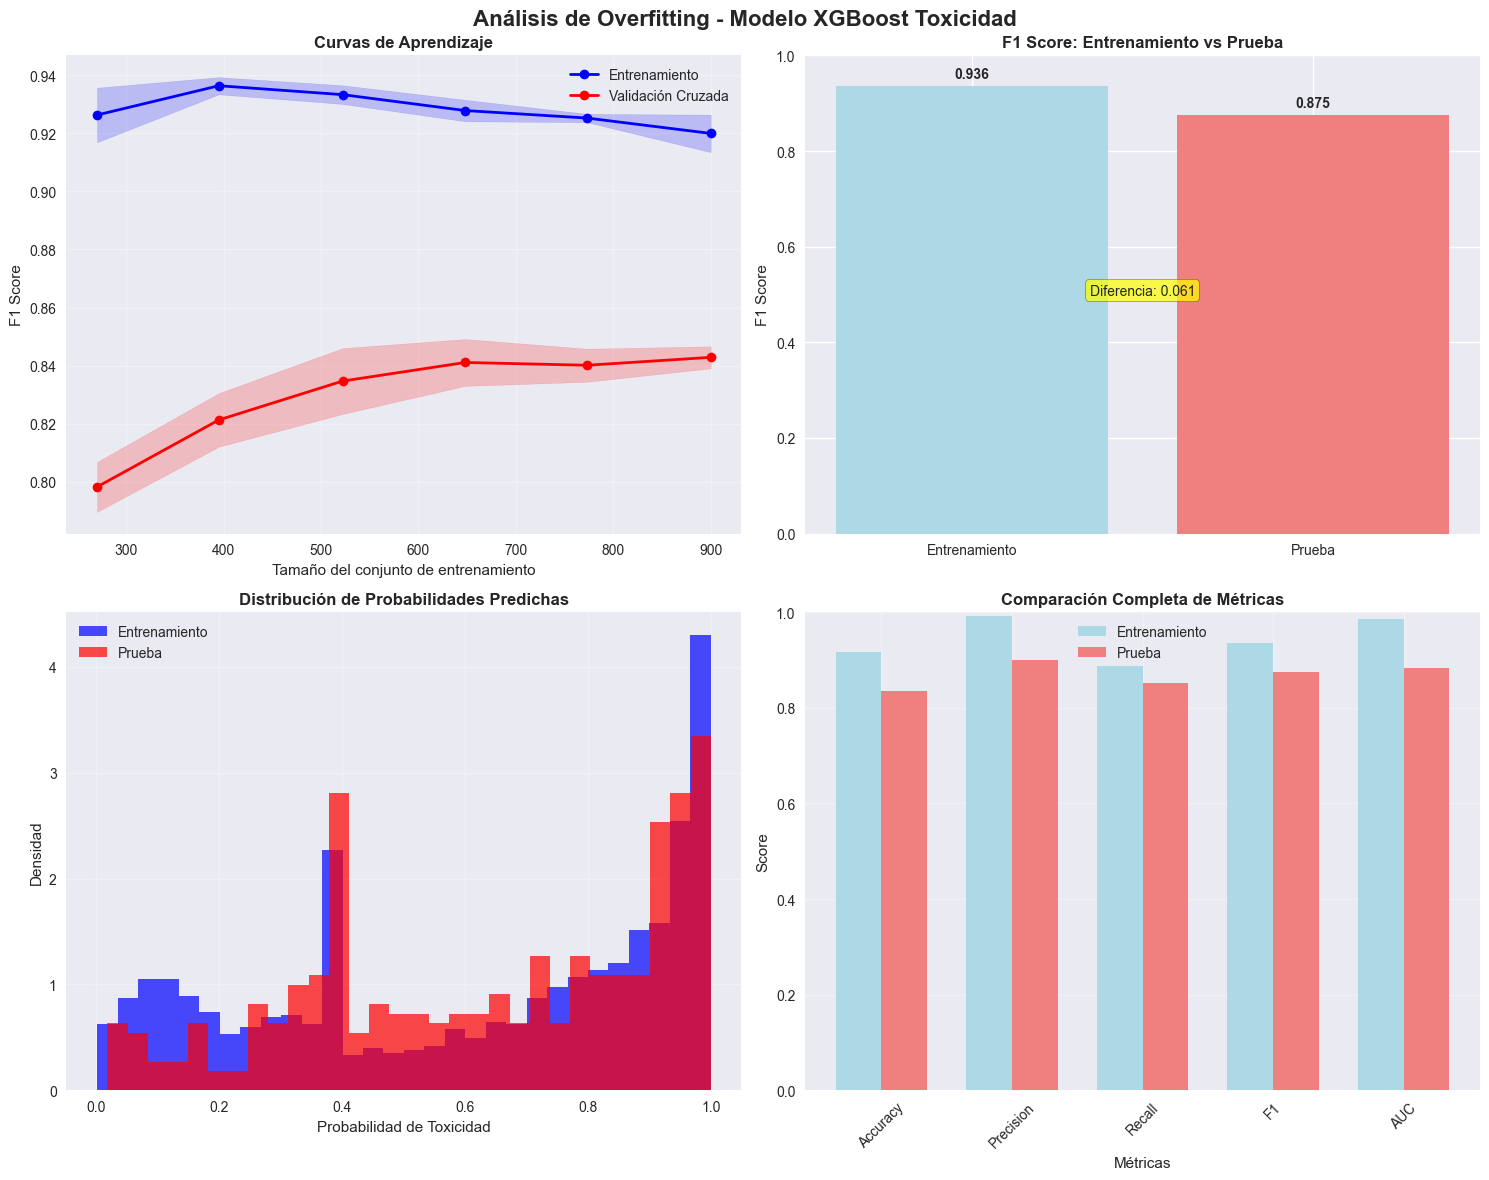


üìã REPORTE FINAL DE OVERFITTING
üìä AN√ÅLISIS DETALLADO:
   ‚Ä¢ F1 Entrenamiento: 0.9363
   ‚Ä¢ F1 Prueba:        0.8750

üîç GAP DE RENDIMIENTO:
   ‚Ä¢ Train-Test gap:   0.0613

ü©∫ DIAGN√ìSTICO:
   ‚ö†Ô∏è  MODERADO: Overfitting detectado

üí° RECOMENDACI√ìN:
   Considerar m√°s regularizaci√≥n o early stopping m√°s agresivo

üéØ CAPACIDAD DE GENERALIZACI√ìN: 8.0/100 üü†
   üëé GENERALIZACI√ìN BAJA - Hay overfitting, revisar modelo

üéØ AN√ÅLISIS ESPEC√çFICO PARA TOXICIDAD:
   ‚Ä¢ Gap Precision: 0.0924
   ‚Ä¢ Gap Recall:    0.0348

‚úÖ AN√ÅLISIS DE OVERFITTING COMPLETADO

üìà AN√ÅLISIS ADICIONAL: DISTRIBUCI√ìN DE CONFIANZA
--------------------------------------------------
üìä Distribuci√≥n de confianza en predicciones de prueba:
   ‚Ä¢ Alta confianza (>80% o <20%):  160 (47.3%)
   ‚Ä¢ Media confianza (60-80%, 20-40%): 130 (38.5%)
   ‚Ä¢ Baja confianza (40-60%):        48 (14.2%)

üéØ Accuracy por nivel de confianza:
   ‚Ä¢ Alta confianza: 0.944
   ‚Ä¢ Media confianza: 0.

In [18]:
def analizar_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test):
    """
    An√°lisis completo de overfitting del modelo XGBoost
    Adaptado para el notebook de detecci√≥n de toxicidad
    """
    
    print("üîç AN√ÅLISIS DE OVERFITTING")
    print("=" * 50)
    
    # 1. M√âTRICAS COMPARATIVAS ENTRE CONJUNTOS
    print("\nüìä COMPARACI√ìN DE M√âTRICAS POR CONJUNTO:")
    print("-" * 40)
    
    conjuntos_datos = {
        'Entrenamiento': (X_train_vec, y_train),
        'Prueba': (X_test_vec, y_test)
    }
    
    comparacion_metricas = {}
    
    for nombre, (X, y) in conjuntos_datos.items():
        y_pred = modelo_xgb.predict(X)
        y_proba = modelo_xgb.predict_proba(X)[:, 1]
        
        metricas = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        comparacion_metricas[nombre] = metricas
        
        print(f"\n{nombre}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica.upper()}: {valor:.4f}")
    
    # 2. DETECTAR OVERFITTING
    print(f"\nüö® DETECCI√ìN DE OVERFITTING:")
    print("-" * 30)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Diferencias
    train_test_diff = train_f1 - test_f1
    
    print(f"üìà F1 Train vs Test: {train_test_diff:.4f}")
    
    # An√°lisis de overfitting
    overfitting_detectado = False
    
    if train_test_diff > 0.08:  # M√°s de 8% de diferencia es preocupante
        print("‚ùå OVERFITTING SEVERO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.05:  # M√°s de 5% de diferencia
        print("‚ö†Ô∏è  OVERFITTING MODERADO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.02:  # Ligero overfitting
        print("‚ö†Ô∏è  LIGERO OVERFITTING detectado")
        overfitting_detectado = True
    
    if not overfitting_detectado:
        print("‚úÖ NO se detecta overfitting significativo")
        print("‚úÖ Modelo tiene buena generalizaci√≥n")
    
    return comparacion_metricas

def graficar_analisis_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas):
    """
    Visualizaciones para an√°lisis de overfitting
    Adaptado para el modelo XGBoost del notebook
    """
    
    print(f"\nüìä GENERANDO VISUALIZACIONES...")
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('An√°lisis de Overfitting - Modelo XGBoost Toxicidad', fontsize=16, fontweight='bold')
    
    # Subplot 1: Curvas de aprendizaje
    print("üìà Calculando curvas de aprendizaje...")
    
    # Crear un modelo XGBoost sin early stopping para las curvas de aprendizaje
    modelo_sin_early_stopping = xgb.XGBClassifier(
        n_estimators=100,  # Menos √°rboles para ser m√°s r√°pido
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
        # NO incluir early_stopping_rounds aqu√≠
    )
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo_sin_early_stopping, X_train_vec, y_train,
        cv=3, 
        train_sizes=np.linspace(0.3, 1.0, 6),  # Empezar con m√°s datos para evitar problemas
        scoring='f1',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0, 0].plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento', linewidth=2)
    axes[0, 0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[0, 0].plot(train_sizes, val_mean, 'o-', color='red', label='Validaci√≥n Cruzada', linewidth=2)
    axes[0, 0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[0, 0].set_xlabel('Tama√±o del conjunto de entrenamiento')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Curvas de Aprendizaje', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Comparaci√≥n de m√©tricas Train vs Test
    conjuntos = ['Entrenamiento', 'Prueba']
    f1_scores = [
        comparacion_metricas['Entrenamiento']['f1'],
        comparacion_metricas['Prueba']['f1']
    ]
    
    colores = ['lightblue', 'lightcoral']
    barras = axes[0, 1].bar(conjuntos, f1_scores, color=colores)
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score: Entrenamiento vs Prueba', fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # A√±adir valores en las barras
    for barra, score in zip(barras, f1_scores):
        axes[0, 1].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # L√≠nea de referencia para mostrar la diferencia
    diferencia = abs(f1_scores[0] - f1_scores[1])
    axes[0, 1].text(0.5, 0.5, f'Diferencia: {diferencia:.3f}', 
                   transform=axes[0, 1].transAxes, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 3: Distribuci√≥n de probabilidades por conjunto
    y_proba_train = modelo_xgb.predict_proba(X_train_vec)[:, 1]
    y_proba_test = modelo_xgb.predict_proba(X_test_vec)[:, 1]
    
    axes[1, 0].hist(y_proba_train, bins=30, alpha=0.7, label='Entrenamiento', color='blue', density=True)
    axes[1, 0].hist(y_proba_test, bins=30, alpha=0.7, label='Prueba', color='red', density=True)
    axes[1, 0].set_xlabel('Probabilidad de Toxicidad')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribuci√≥n de Probabilidades Predichas', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Todas las m√©tricas comparadas
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    train_metricas = [comparacion_metricas['Entrenamiento'][m.lower()] for m in metricas]
    test_metricas = [comparacion_metricas['Prueba'][m.lower()] for m in metricas]
    
    x = np.arange(len(metricas))
    ancho = 0.35
    
    axes[1, 1].bar(x - ancho/2, train_metricas, ancho, label='Entrenamiento', color='lightblue')
    axes[1, 1].bar(x + ancho/2, test_metricas, ancho, label='Prueba', color='lightcoral')
    
    axes[1, 1].set_xlabel('M√©tricas')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Comparaci√≥n Completa de M√©tricas', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metricas, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def generar_reporte_overfitting(comparacion_metricas):
    """
    Generar reporte final de overfitting
    """
    
    print(f"\nüìã REPORTE FINAL DE OVERFITTING")
    print("=" * 50)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # An√°lisis detallado
    print(f"üìä AN√ÅLISIS DETALLADO:")
    print(f"   ‚Ä¢ F1 Entrenamiento: {train_f1:.4f}")
    print(f"   ‚Ä¢ F1 Prueba:        {test_f1:.4f}")
    
    gap_train_test = train_f1 - test_f1
    
    print(f"\nüîç GAP DE RENDIMIENTO:")
    print(f"   ‚Ä¢ Train-Test gap:   {gap_train_test:.4f}")
    
    # Diagn√≥stico
    print(f"\nü©∫ DIAGN√ìSTICO:")
    
    if gap_train_test < 0.02:
        print("   ‚úÖ EXCELENTE: Modelo muy bien generalizado")
        recomendacion = "El modelo est√° listo para producci√≥n"
        color_estado = "üü¢"
        
    elif gap_train_test < 0.05:
        print("   ‚úÖ BUENO: Ligero overfitting, pero aceptable")
        recomendacion = "Modelo aceptable para producci√≥n con monitoreo"
        color_estado = "üü°"
        
    elif gap_train_test < 0.08:
        print("   ‚ö†Ô∏è  MODERADO: Overfitting detectado")
        recomendacion = "Considerar m√°s regularizaci√≥n o early stopping m√°s agresivo"
        color_estado = "üü†"
        
    else:
        print("   ‚ùå SEVERO: Overfitting significativo")
        recomendacion = "Necesario ajustar hiperpar√°metros o reentrenar"
        color_estado = "üî¥"
    
    print(f"\nüí° RECOMENDACI√ìN:")
    print(f"   {recomendacion}")
    
    # M√©tricas de generalizaci√≥n (no "confianza" para evitar confusi√≥n)
    puntaje_generalizacion = max(0, 100 - (gap_train_test * 100 * 15))
    print(f"\nüéØ CAPACIDAD DE GENERALIZACI√ìN: {puntaje_generalizacion:.1f}/100 {color_estado}")
    
    if puntaje_generalizacion >= 85:
        print("   üèÜ EXCELENTE generalizaci√≥n - Modelo muy robusto")
    elif puntaje_generalizacion >= 70:
        print("   üëç BUENA generalizaci√≥n - Modelo confiable")
    elif puntaje_generalizacion >= 50:
        print("   ‚ö†Ô∏è  GENERALIZACI√ìN MEDIA - Modelo aceptable con reservas")
    else:
        print("   üëé GENERALIZACI√ìN BAJA - Hay overfitting, revisar modelo")
    
    # An√°lisis adicional espec√≠fico para detecci√≥n de toxicidad
    print(f"\nüéØ AN√ÅLISIS ESPEC√çFICO PARA TOXICIDAD:")
    
    train_precision = comparacion_metricas['Entrenamiento']['precision']
    test_precision = comparacion_metricas['Prueba']['precision']
    precision_gap = train_precision - test_precision
    
    train_recall = comparacion_metricas['Entrenamiento']['recall']
    test_recall = comparacion_metricas['Prueba']['recall']
    recall_gap = train_recall - test_recall
    
    print(f"   ‚Ä¢ Gap Precision: {precision_gap:.4f}")
    print(f"   ‚Ä¢ Gap Recall:    {recall_gap:.4f}")
    
    if precision_gap > 0.1:
        print("   ‚ö†Ô∏è  Modelo podr√≠a estar generando muchos falsos positivos en producci√≥n")
    if recall_gap > 0.1:
        print("   ‚ö†Ô∏è  Modelo podr√≠a estar perdiendo comentarios t√≥xicos en producci√≥n")

# EJECUTAR AN√ÅLISIS COMPLETO DE OVERFITTING
# 1. Analizar overfitting con las m√©tricas
comparacion_metricas = analizar_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test
)

# 2. Generar visualizaciones
graficar_analisis_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas
)

# 3. Generar reporte final
generar_reporte_overfitting(comparacion_metricas)

print(f"\n‚úÖ AN√ÅLISIS DE OVERFITTING COMPLETADO")
print("="*70)

# AN√ÅLISIS ADICIONAL: PREDICCIONES POR CONFIANZA
print(f"\nüìà AN√ÅLISIS ADICIONAL: DISTRIBUCI√ìN DE CONFIANZA")
print("-" * 50)

# Analizar las predicciones por nivel de confianza
y_proba_test = modelo.predict_proba(X_test_vec)[:, 1]

# Categorizar predicciones por confianza
alta_confianza = (y_proba_test >= 0.8) | (y_proba_test <= 0.2)
media_confianza = ((y_proba_test >= 0.6) & (y_proba_test < 0.8)) | ((y_proba_test > 0.2) & (y_proba_test <= 0.4))
baja_confianza = (y_proba_test > 0.4) & (y_proba_test < 0.6)

print(f"üìä Distribuci√≥n de confianza en predicciones de prueba:")
print(f"   ‚Ä¢ Alta confianza (>80% o <20%):  {alta_confianza.sum():3d} ({alta_confianza.mean()*100:.1f}%)")
print(f"   ‚Ä¢ Media confianza (60-80%, 20-40%): {media_confianza.sum():3d} ({media_confianza.mean()*100:.1f}%)")
print(f"   ‚Ä¢ Baja confianza (40-60%):       {baja_confianza.sum():3d} ({baja_confianza.mean()*100:.1f}%)")

# Calcular accuracy por nivel de confianza
if alta_confianza.sum() > 0:
    acc_alta = accuracy_score(y_test[alta_confianza], (y_proba_test[alta_confianza] > 0.5))
    print(f"\nüéØ Accuracy por nivel de confianza:")
    print(f"   ‚Ä¢ Alta confianza: {acc_alta:.3f}")

if media_confianza.sum() > 0:
    acc_media = accuracy_score(y_test[media_confianza], (y_proba_test[media_confianza] > 0.5))
    print(f"   ‚Ä¢ Media confianza: {acc_media:.3f}")

if baja_confianza.sum() > 0:
    acc_baja = accuracy_score(y_test[baja_confianza], (y_proba_test[baja_confianza] > 0.5))
    print(f"   ‚Ä¢ Baja confianza: {acc_baja:.3f}")

print(f"\nüí° Interpretaci√≥n:")
if baja_confianza.mean() < 0.15:  # Menos del 15% de predicciones inciertas
    print("   ‚úÖ Modelo hace predicciones con alta certeza individual")
    print("   üìä La mayor√≠a de predicciones son muy seguras (>80% o <20%)")
else:
    print("   ‚ö†Ô∏è  Considerable n√∫mero de predicciones con baja certeza")
    print("   üìä Muchas predicciones est√°n en zona gris (40-60%)")

print(f"\nüèÅ AN√ÅLISIS COMPLETO FINALIZADO")
print("="*70)

# 15. Optimizaci√≥n con Optuna

In [ ]:
def objective(trial):
    """Funci√≥n objetivo para optimizar hiperpar√°metros anti-overfitting"""
    try:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'objective': 'binary:logistic',
            'random_state': 42,
            'n_jobs': 1,  # Usar 1 core para evitar conflictos en CV
            'scale_pos_weight': scale_pos_weight,
            'verbosity': 0
        }
        
        # Modelo para validaci√≥n cruzada (sin early stopping)
        modelo_cv = xgb.XGBClassifier(**params)
        
        # Validaci√≥n cruzada
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reducido a 3 folds
        f1_scores = cross_val_score(
            modelo_cv, X_train_vec, y_train, 
            cv=cv, scoring='f1', error_score='raise'
        )
        
        # Evaluar overfitting con modelo simple
        modelo_test = xgb.XGBClassifier(**{**params, 'n_estimators': 100})
        modelo_test.fit(X_train_vec, y_train)
        
        train_f1 = f1_score(y_train, modelo_test.predict(X_train_vec))
        test_f1 = f1_score(y_test, modelo_test.predict(X_test_vec))
        overfitting_gap = abs(train_f1 - test_f1)
        
        # Guardar m√©tricas
        trial.set_user_attr('cv_f1', f1_scores.mean())
        trial.set_user_attr('cv_f1_std', f1_scores.std())
        trial.set_user_attr('train_f1', train_f1)
        trial.set_user_attr('test_f1', test_f1)
        trial.set_user_attr('overfitting_gap', overfitting_gap)
        
        # Penalizar overfitting
        return f1_scores.mean() - (overfitting_gap * 1.5)
        
    except Exception as e:
        print(f"Error en trial: {e}")
        return -1.0  # Score muy bajo para trials fallidos

def optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Optimiza hiperpar√°metros usando Optuna"""
    # Hacer variables globales para objective
    globals().update({
        'X_train_vec': X_train_vec, 'y_train': y_train,
        'X_test_vec': X_test_vec, 'y_test': y_test
    })
    
    # Verificar que los datos sean v√°lidos
    print(f"Datos de entrenamiento: {X_train_vec.shape}, {len(y_train)}")
    print(f"Datos de prueba: {X_test_vec.shape}, {len(y_test)}")
    print(f"Distribuci√≥n y_train: {np.bincount(y_train)}")
    
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Filtrar trials exitosos
    successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value > -0.5]
    
    if not successful_trials:
        raise ValueError("No se completaron trials exitosos. Revisa tus datos.")
    
    best_trial = max(successful_trials, key=lambda x: x.value)
    
    print(f"\nMejor score: {best_trial.value:.4f}")
    print(f"CV F1: {best_trial.user_attrs['cv_f1']:.4f} (¬±{best_trial.user_attrs['cv_f1_std']:.4f})")
    print(f"Train F1: {best_trial.user_attrs['train_f1']:.4f}")
    print(f"Test F1: {best_trial.user_attrs['test_f1']:.4f}")
    print(f"Gap overfitting: {best_trial.user_attrs['overfitting_gap']:.4f}")
    print(f"Trials exitosos: {len(successful_trials)}/{len(study.trials)}")
    
    return best_trial.params

def entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test):
    """Entrena modelo final con par√°metros optimizados"""
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    final_params = {
        **best_params,
        'objective': 'binary:logistic',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0
    }
    
    modelo = xgb.XGBClassifier(**final_params)
    modelo.fit(X_train_vec, y_train)
    
    # Evaluaci√≥n final
    train_pred = modelo.predict(X_train_vec)
    test_pred = modelo.predict(X_test_vec)
    
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Validaci√≥n cruzada final
    cv_scores = cross_val_score(
        xgb.XGBClassifier(**final_params), 
        X_train_vec, y_train, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
        scoring='f1'
    )
    
    print(f"\n‚úÖ Modelo final:")
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"CV F1: {cv_scores.mean():.3f} (¬±{cv_scores.std() * 2:.3f})")
    print(f"Overfitting gap: {abs(train_f1 - test_f1):.4f}")
    
    return modelo, final_params

def optimizar_y_entrenar(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Proceso completo de optimizaci√≥n y entrenamiento"""
    print("üöÄ Optimizando XGBoost con Optuna...")
    
    # Verificaciones iniciales
    if len(np.unique(y_train)) != 2:
        raise ValueError("y_train debe ser binario (0 y 1)")
    
    if X_train_vec.shape[0] != len(y_train):
        raise ValueError("X_train_vec y y_train deben tener el mismo n√∫mero de filas")
    
    best_params = optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials)
    modelo_final, final_params = entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test)
    
    return modelo_final, final_params

def guardar_modelos(modelo, vectorizer, nombre_base="modelo_toxicidad_xgboost"):
    """Guarda el modelo y vectorizer en archivos pickle"""
    import pickle
    
    # Nombres de archivos
    nombre_modelo = f"../final_model/{nombre_base}_final.pkl"
    nombre_vectorizer = f"../final_model/vectorizer_toxicidad_final.pkl"
    
    try:
        # Guardar modelo
        with open(nombre_modelo, 'wb') as f:
            pickle.dump(modelo, f)
        
        # Guardar vectorizer
        with open(nombre_vectorizer, 'wb') as f:
            pickle.dump(vectorizer, f)
        
        print(f"‚úÖ Archivos guardados exitosamente:")
        print(f"   - {nombre_modelo}")
        print(f"   - {nombre_vectorizer}")
        
        return True
        
    except Exception as e:
        print(f"‚ùå Error al guardar archivos: {e}")
        return False

# C√ìDIGO PRINCIPAL DE EJECUCI√ìN
try:
    # Ejecutar optimizaci√≥n
    modelo_optimizado, params_optimizados = optimizar_y_entrenar(
        X_train_vec, y_train, X_test_vec, y_test, n_trials=20  # Empezar con pocos trials
    )
    
    # Mostrar mejores par√°metros
    print("\nüîß MEJORES PAR√ÅMETROS ENCONTRADOS:")
    for param, valor in params_optimizados.items():
        if param not in ['objective', 'random_state', 'n_jobs', 'scale_pos_weight', 'verbosity']:
            if isinstance(valor, float):
                print(f"   {param}: {valor:.4f}")
            else:
                print(f"   {param}: {valor}")
    
    print(f"\nüéØ Optimizaci√≥n completada exitosamente!")
    
    # Guardar modelos   
    if 'vectorizer' in globals():
        guardar_modelos(modelo_optimizado, vectorizer)
    else:
        print("‚ö†Ô∏è  Advertencia: 'vectorizer' no est√° definido. Solo guardando el modelo.")
        import pickle
        with open('../final_model/modelo_toxicidad_xgboost_final.pkl', 'wb') as f:
            pickle.dump(modelo_optimizado, f)
        print("‚úÖ Modelo guardado: ../final_model/modelo_toxicidad_xgboost_final.pkl")
    
except Exception as e:
    print(f"‚ùå Error durante la optimizaci√≥n: {e}")
    print("\nüîç Verificando datos...")
    
    # Diagn√≥stico de datos
    print(f"Forma X_train_vec: {X_train_vec.shape if 'X_train_vec' in globals() else 'No definido'}")
    print(f"Forma y_train: {y_train.shape if 'y_train' in globals() else 'No definido'}")
    print(f"Forma X_test_vec: {X_test_vec.shape if 'X_test_vec' in globals() else 'No definido'}")
    print(f"Forma y_test: {y_test.shape if 'y_test' in globals() else 'No definido'}")
    
    if 'y_train' in globals():
        print(f"Valores √∫nicos en y_train: {np.unique(y_train)}")
        print(f"Distribuci√≥n y_train: {np.bincount(y_train)}")
    
    if 'X_train_vec' in globals():
        print(f"Tipo X_train_vec: {type(X_train_vec)}")
        print(f"¬øHay NaN en X_train_vec?: {np.isnan(X_train_vec).any() if hasattr(X_train_vec, 'shape') else 'No es array'}")
    
    print("\nüí° Sugerencias:")
    print("1. Aseg√∫rate de que y_train e y_test contengan solo 0s y 1s")
    print("2. Verifica que no hay valores NaN en los datos")
    print("3. Confirma que X_train_vec y y_train tienen el mismo n√∫mero de filas")

[I 2025-07-08 10:47:47,566] A new study created in memory with name: no-name-f9451fd5-5045-48da-ba28-6108deb17bbf


üöÄ Optimizando XGBoost con Optuna...
Datos de entrenamiento: (1350, 2000), 1350
Datos de prueba: (338, 2000), 338
Distribuci√≥n y_train: [430 920]


  0%|          | 0/20 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.456445:   5%|‚ñå         | 1/20 [00:05<01:43,  5.44s/it]

[I 2025-07-08 10:47:53,004] Trial 0 finished with value: 0.4564450469503847 and parameters: {'n_estimators': 144, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8197316968394073, 'colsample_bytree': 0.7312037280884873, 'reg_alpha': 0.7884126564776512, 'reg_lambda': 0.29983722471931534, 'min_child_weight': 7}. Best is trial 0 with value: 0.4564450469503847.


Best trial: 1. Best value: 0.704646:  10%|‚ñà         | 2/20 [00:18<02:54,  9.68s/it]

[I 2025-07-08 10:48:05,652] Trial 1 finished with value: 0.704645861772653 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.8939819704323989, 'colsample_bytree': 0.8664885281600844, 'reg_alpha': 1.0695721622845982, 'reg_lambda': 0.9173065863634321, 'min_child_weight': 2}. Best is trial 1 with value: 0.704645861772653.


Best trial: 1. Best value: 0.704646:  15%|‚ñà‚ñå        | 3/20 [00:23<02:10,  7.67s/it]

[I 2025-07-08 10:48:10,926] Trial 2 finished with value: 0.6167379971518696 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.13526405540621358, 'subsample': 0.7582458280396084, 'colsample_bytree': 0.8223705789444758, 'reg_alpha': 0.7060743646536888, 'reg_lambda': 1.4678017961907386, 'min_child_weight': 3}. Best is trial 1 with value: 0.704645861772653.


Best trial: 1. Best value: 0.704646:  20%|‚ñà‚ñà        | 4/20 [00:34<02:25,  9.10s/it]

[I 2025-07-08 10:48:22,217] Trial 3 finished with value: 0.6679467380191797 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.06790539682592432, 'subsample': 0.8028468876827223, 'colsample_bytree': 0.8184829137724084, 'reg_alpha': 0.24178755947278865, 'reg_lambda': 3.0416488109881774, 'min_child_weight': 2}. Best is trial 1 with value: 0.704645861772653.


Best trial: 1. Best value: 0.704646:  25%|‚ñà‚ñà‚ñå       | 5/20 [00:41<02:01,  8.11s/it]

[I 2025-07-08 10:48:28,563] Trial 4 finished with value: 0.5815770092932193 and parameters: {'n_estimators': 66, 'max_depth': 8, 'learning_rate': 0.2900332895916222, 'subsample': 0.8616794696232922, 'colsample_bytree': 0.7609227538346741, 'reg_alpha': 0.49738384889185555, 'reg_lambda': 3.424322802295663, 'min_child_weight': 4}. Best is trial 1 with value: 0.704645861772653.


Best trial: 1. Best value: 0.704646:  25%|‚ñà‚ñà‚ñå       | 5/20 [00:46<02:20,  9.33s/it]


[W 2025-07-08 10:48:33,437] Trial 5 failed with parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.019972671123413333, 'subsample': 0.8818640804157565, 'colsample_bytree': 0.7517559963200033, 'reg_alpha': 3.31598619892637, 'reg_lambda': 1.5654382696861608, 'min_child_weight': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Marie\AppData\Local\Temp\ipykernel_25396\1160314308.py", line 34, in objective
    modelo_test.fit(X_train_vec, y_train)
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = 

KeyboardInterrupt: 

# 16. RESUMEN FINAL

In [ ]:
print("\n" + "="*60)
print("üéâ RESUMEN DEL PROYECTO")
print("="*60)

print(f"""
üìä Dataset:
   - Comentarios originales: 1,000
   - Despu√©s de augmentation: {len(df_final)}
   - Balance final: {df_final['toxic_binary'].mean()*100:.1f}% t√≥xicos

üßπ Preprocesamiento:
   - Columnas eliminadas: {len(columnas_eliminar)} (desbalanceadas)
   - Columnas usadas: {len(columnas_mantener)}
   - T√©cnica: Limpieza + Lemmatizaci√≥n

üîÑ Data Augmentation:
   - M√©todo: Variaciones de texto
   - Comentarios t√≥xicos aumentados: {len(df_aumentados)}

ü§ñ Modelo:
   - Algoritmo: XGBoost
   - Par√°metros: 300 √°rboles, profundidad 6, early stopping
   - Vectorizaci√≥n: TF-IDF (2000 features, n-gramas 1-3)
   - Performance: F1-Score = {f1:.3f}

‚úÖ Archivos generados:
   - dataset_toxicidad_aumentado.csv
   - modelo_toxicidad_xgboost_final.pkl
   - vectorizer_toxicidad_final.pkl
""")


üéâ RESUMEN DEL PROYECTO

üìä Dataset:
   - Comentarios originales: 1,000
   - Despu√©s de augmentation: 1688
   - Balance final: 68.1% t√≥xicos

üßπ Preprocesamiento:
   - Columnas eliminadas: 6 (desbalanceadas)
   - Columnas usadas: 5
   - T√©cnica: Limpieza + Lemmatizaci√≥n

üîÑ Data Augmentation:
   - M√©todo: Variaciones de texto
   - Comentarios t√≥xicos aumentados: 688

ü§ñ Modelo:
   - Algoritmo: XGBoost
   - Par√°metros: 300 √°rboles, profundidad 6, early stopping
   - Vectorizaci√≥n: TF-IDF (2000 features, n-gramas 1-3)
   - Performance: F1-Score = 0.876

‚úÖ Archivos generados:
   - dataset_toxicidad_aumentado.csv
   - modelo_toxicidad_xgboost_final.pkl
   - vectorizer_toxicidad_final.pkl

